# R-peak Detection

This example contains the code for training a deep learning model for the R-peak detection task. In this example, the electrocardiogram signals are segmented into ten-second ecxerpts. Each excerpt is associated with an annotation list of length 600, containing zeros and ones. A subsegment of an excerpt that contains an R-peak corresponds to 1 in the annotation list. To achieve this goal, the `RpeakData` class is used to create the required train, validation, and test datasets.  Each dataset consists of signals and annotations, as well as metadata about the excerpts. The metadata for each excerpt includes the record ID, the onset and offset of the excerpt on the raw signal, and the annotation.

This example is availble on [GitHub](https://github.com/devnums/pyheartlib/blob/main/examples/).

<a target="_blank" href="https://colab.research.google.com/github/devnums/pyheartlib/blob/main/examples/model/rpeak_detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Pyheartlib

In [1]:
try:
    import pyheartlib
    print(f'Pyheartlib version {pyheartlib.__version__} is already installed!')
except ModuleNotFoundError:
    print('Installing pyheartlib...')
    %pip install pyheartlib
    print(f'Pyheartlib version {pyheartlib.__version__} is installed!')

Pyheartlib version 1.20.1 is already installed!


## Download raw data

This section downloads the raw data and store them in the data directory.

In [2]:
# Download the raw data and store them in the base data directory
from pathlib import Path

if not Path("data").is_dir():
    print("downloading raw data...")
    import io, zipfile
    from urllib.request import urlopen

    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    with urlopen(url) as rs:
        zipf = zipfile.ZipFile(io.BytesIO(rs.read()))
        zipf.extractall("data/")

    # Create the config file. For this example, it will be download from the original repository
    with urlopen(
        "https://raw.githubusercontent.com/devnums/pyheartlib/main/src/pyheartlib/config.yaml"
    ) as file:
        content = file.read().decode()
    with open("data/config.yaml", "w") as file:
        file.write(content)


## Create dataset

The raw dataset contains several ECG records, each of which is 30 minutes long. In order to create the required datasets, `RpeakData` class is used. The datasets comprise the signals and their annotations, as well as the metadata required to extract ten-second signal excerpts. `RpeakData` class utilizes a sliding window to determine the onset and offset of the signal excerpts. The length of the excerpts is determined by the win_size parameter, and the degree of overlap between excerpts is determined by the stride parameter. Here, 18 records are used for the train dataset, 4 for validation, and 22 for the test dataset.

In [3]:
import os

from pyheartlib.data_rpeak import ECGSequence, RpeakData
from pyheartlib.data_rpeak import load_dataset

data_dir = "data"
# Make an instance of the RpeakData
rpeak_data = RpeakData(
    base_path=data_dir, remove_bl=False, lowpass=False, progress_bar=False
)

# Define record names
train_set = rpeak_data.config["DS1"][:18]
validation_set = rpeak_data.config["DS1"][18:]
test_set = rpeak_data.config["DS2"]

# Create train dataset
# The win_size specifies the length of the excerpts
rpeak_data.save_dataset(
    rec_list=train_set,
    file_name="train.rpeak",
    win_size=10 * 360,
    stride=1440,
    interval=6,
)

# Create validation dataset
rpeak_data.save_dataset(
    rec_list=validation_set,
    file_name="validation.rpeak",
    win_size=10 * 360,
    stride=1440,
    interval=6,
)

# Create test dataset
rpeak_data.save_dataset(
    rec_list=test_set,
    file_name="test.rpeak",
    win_size=10 * 360,
    stride=1440,
    interval=6,
)

File saved at: data/train.rpeak
File saved at: data/validation.rpeak
File saved at: data/test.rpeak


In [4]:
# Verify the dataset

# Load train dataset
train_data = os.path.join(data_dir, "train.rpeak")
annotated_records, samples_info = load_dataset(train_data)
print("Number of samples in the train dataset:", str(len(samples_info)))
print("\nExample metadata for a data sample ([record ID,onset,offset,annotation]):")
print(samples_info[1])

File loaded from: data/train.rpeak
Number of samples in the train dataset: 8082

Example metadata for a data sample ([record ID,onset,offset,annotation]):
[0, 1440, 5040, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'N', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'N', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'N', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'N', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'N', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
# Verify the dataset - continue

# Generate data in batch using he ECGSequence
trainseq = ECGSequence(
    annotated_records,
    samples_info,
    binary=True,
    batch_size=1,
    raw=True,
    interval=6,
)

bt = 0  # Batch number
batch_annotation = trainseq[bt][1]  # Annotation
batch_wave = trainseq[bt][0]  # Excerpt values


print("Length of annotation for each sample data:", len(batch_annotation[0]))
print("Length of each sample excerpt:", batch_wave.shape[2])
print(
    "Each excerpt is associated with an annotation of length 600, containing zeros and ones."
)


Length of annotation for each sample data: 600
Length of each sample excerpt: 3600
Each excerpt is associated with an annotation of length 600, containing zeros and ones.


Plot an excerpt.

Length of each excerpt: 3600


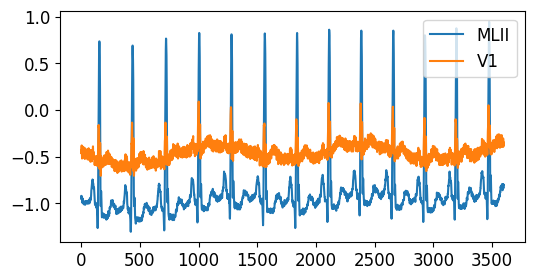

In [15]:
# Plot an output excerpt of the batch
wf = batch_wave[0]
wf_ch1 = wf[0]
wf_ch2 = wf[1]
print(f'Length of each excerpt: {len(wf_ch1)}')

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.plot(wf_ch1);
plt.plot(wf_ch2);
chs = rpeak_data.config["CHANNEL"]
plt.legend([chs[0], chs[1]], loc="upper right");

## Model architecture

The input to this example deep learning model is a signal excerpt of length 3600 (10 seconds with a sampling rate of 360), and the output is an array of length 600 containing probabilities of a binary classification. A 1 in the classification output indicates that there is an R-peak in the relevant subsegment, and a 0 indicates that there is no R-peak in that subsegment. Only the first channel (MLII) is used.

In [7]:
# Model architecture
import tensorflow as tf
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPool1D,
)


def reg():
    return tf.keras.regularizers.l2(l=0.01)


def conv1d_block(
    inp,
    name=None,
    filters=64,
    kernel_size=64,
    bn=True,
    drate=0.30,
    pool_size=0,
    flatten=True,
    regularizer=None,
):
    output = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding="same",
        activation=None,
        kernel_regularizer=regularizer,
    )(inp)
    if bn:
        output = BatchNormalization(axis=-1)(output)
    output = Activation("relu")(output)
    if drate > 0:
        output = Dropout(drate)(output)
    if pool_size > 0:
        output = MaxPool1D(pool_size=pool_size)(output)
    if flatten:
        output = Flatten()(output)
    return output


def model_arch(params_model):
    x_input_dim = int(params_model["x_input_dim"])
    num_classes = int(params_model["num_classes"])
    input1_layer = Input(shape=(None, x_input_dim), name="x_input_dim")
    out = tf.gather(input1_layer, tf.constant([0]), axis=1)
    out = tf.squeeze(input=out, axis=1)
    out = tf.expand_dims(out, axis=-1)
    out = BatchNormalization()(out)
    out = conv1d_block(
        out,
        name="block1",
        filters=16,
        kernel_size=6,
        bn=True,
        drate=0.2,
        pool_size=6,
        flatten=False,
    )
    out = Activation("relu")(out)
    out = Bidirectional(LSTM(32, return_sequences=True))(out)
    out = Dropout(0.2)(out)
    out = Bidirectional(LSTM(32, return_sequences=True))(out)
    out = Dropout(0.2)(out)
    out = Dense(64, activation="relu")(out)
    out = Dropout(0.2)(out)
    out = Dense(num_classes, activation="softmax")(out)
    return tf.keras.Model(inputs=input1_layer, outputs=out, name="model_rpeak")

## Train model

The example model is trained in this section. The train dataset is used for training purposes, while the validation dataset is utilized for validation purposes. The loss function is the sparse categorical cross entropy, and the Adam optimizer is used for optimization. Each batch contains 32 samples, and the model is trained for three epochs.

In [8]:
import os

from pyheartlib.extra.utils import reset_seed
from pyheartlib.data_rpeak import load_dataset

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf  # noqa: E402

data_dir = "data"
train_data = os.path.join(data_dir, "train.rpeak")
val_data = os.path.join(data_dir, "validation.rpeak")
mdl_checkpoint = os.path.join(os.getcwd(), "checkpoint/keras.exp")

interval_value = 6

reset_seed()

# Load train dataset
annotated_records, samples_info = load_dataset(train_data)
print("Train dataset loaded. Number of sampels:", str(len(samples_info)))

labels = []
for sample in samples_info:
    labels.append(sample[3])

params_model = {
    "x_input_dim": samples_info[0][2] - samples_info[0][1],  # win size
    "out_seq_len": len(labels[0]),
    "num_classes": 2,
    "regularizer": None,
}
params_train = {"batch_size": 32, "epochs": 3}

mymodel = model_arch(params_model)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adam"
)
mymodel.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    loss_weights=None,
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=8, verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0001,
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    mdl_checkpoint,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)
import time  # noqa: E402

batch_sleep = tf.keras.callbacks.LambdaCallback(
    on_batch_end=lambda batch, logs: time.sleep(0.0001)
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]
# callbacks = [batch_sleep]

from pyheartlib.data_rpeak import ECGSequence  # noqa: E402

trainseq = ECGSequence(
    annotated_records,
    samples_info,
    binary=True,
    batch_size=params_train["batch_size"],
    raw=True,
    interval=interval_value,
)

# Load validation dataset
annotated_records_val, samples_info_val = load_dataset(val_data)

validationseq = ECGSequence(
    annotated_records_val,
    samples_info_val,
    binary=True,
    batch_size=params_train["batch_size"],
    raw=True,
    interval=interval_value,
)

# Train model
if not Path("checkpoint").is_dir():
    model_history = mymodel.fit(
        x=trainseq,
        validation_data=validationseq,
        use_multiprocessing=True,
        # workers=2,
        epochs=params_train["epochs"],
        verbose=1,
        callbacks=callbacks,
    )
else:
    print("The model has been trained before!")


File loaded from: data/train.rpeak
Train dataset loaded. Number of sampels: 8082
File loaded from: data/validation.rpeak
The model has been trained before!


## Inference

This section performs the inference on the test dataset. Classification report and confusion matrix are stored in a file. Additionally, several plots illustrating the prediction outcomes are saved.

In [9]:
# Inference --> result.txt
import os
import textwrap

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

from pyheartlib.data_rpeak import load_dataset

data_dir = "data"
test_data = os.path.join(data_dir, "test.rpeak")
mdl_checkpoint = os.path.join(os.getcwd(), "checkpoint/keras.exp")
interval_value = 6

# Load trained model
loaded_model = tf.keras.models.load_model(mdl_checkpoint)

# Load test dataset
annotated_records_test, samples_info_test = load_dataset(test_data)
print("Train dataset loaded. Number of sampels:", str(len(samples_info_test)))

from pyheartlib.data_rpeak import ECGSequence  # noqa: E402

batch_size = 128
testseq = ECGSequence(
    annotated_records_test,
    samples_info_test,
    binary=True,
    batch_size=batch_size,
    raw=True,
    interval=interval_value,
    shuffle=False,
)
labels_true = []
labels_pred = []
for i in tqdm(range(round(len(samples_info_test) / batch_size))):
    samples = testseq[i]
    labels_true.extend(samples[1])
    probs = loaded_model.predict(samples[0], verbose=0)  # predict
    labels_pred.extend(list(np.argmax(probs, axis=-1)))
labels_true = np.array(labels_true)
labels_pred = np.array(labels_pred)
assert labels_true.shape == labels_pred.shape

# Print classification_report and confusion_matrix
true = labels_true.flatten()
pred = labels_pred.flatten()
# print(classification_report(true, pred))
# print(confusion_matrix(true, pred))
with open("./result.txt", "w") as f:
    title = (
        "************************************************************"
        "Without considering adjacency of ground truth and prediction"
    )
    print(textwrap.fill(title, width=60, replace_whitespace=False), file=f)
    print("\n", file=f)
    print(classification_report(true, pred), file=f)
    print("Confusion Matrix", file=f)
    print(confusion_matrix(true, pred), file=f)
    print("\n", file=f)


def post_tolerance(true, pred):
    # Give a tolerance for nearby segments (False positive)
    # when a False Positve is very adjacent to ground truth peak
    new_pred = np.copy(pred)
    for indx, _ in enumerate(pred):
        if pred[indx] == 1:
            if true[indx] != 1:
                if true[indx + 1] == 1:
                    new_pred[indx + 1] = 1
                    new_pred[indx] = 0
                elif true[indx - 1] == 1:
                    new_pred[indx - 1] = 1
                    new_pred[indx] = 0
                elif true[indx + 2] == 1:
                    new_pred[indx + 2] = 1
                    new_pred[indx] = 0
                elif true[indx - 2] == 1:
                    new_pred[indx - 2] = 1
                    new_pred[indx] = 0
                if true[indx + 3] == 1:
                    new_pred[indx + 3] = 1
                    new_pred[indx] = 0
                elif true[indx - 3] == 1:
                    new_pred[indx - 3] = 1
                    new_pred[indx] = 0
                if true[indx + 4] == 1:
                    new_pred[indx + 4] = 1
                    new_pred[indx] = 0
                elif true[indx - 4] == 1:
                    new_pred[indx - 4] = 1
                    new_pred[indx] = 0
                if true[indx + 5] == 1:
                    new_pred[indx + 5] = 1
                    new_pred[indx] = 0
                elif true[indx - 5] == 1:
                    new_pred[indx - 5] = 1
                    new_pred[indx] = 0
    return new_pred


# Print classification_report and confusion_matrix
new_pred = post_tolerance(true, pred)
pred = new_pred
# print(classification_report(true, pred))
# print(confusion_matrix(true, pred))
with open("./result.txt", "a") as f:
    title = (
        "************************************************************"
        "The results below were obtained by considering a very small"
        "  tolerance for the adjacency of ground truth and prediction"
    )
    print(textwrap.fill(title, width=60, replace_whitespace=False), file=f)
    print("\n", file=f)
    print(classification_report(true, pred), file=f)
    print("Confusion Matrix", file=f)
    print(confusion_matrix(true, pred), file=f)


File loaded from: data/test.rpeak
Train dataset loaded. Number of sampels: 8082


100%|██████████| 63/63 [01:40<00:00,  1.60s/it]


In [10]:
# Inference --> plots
import os

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import pathlib

from pyheartlib.data_rpeak import load_dataset

data_dir = "data"
test_data = os.path.join(data_dir, "test.rpeak")
mdl_checkpoint = os.path.join(os.getcwd(), "checkpoint/keras.exp")
interval_value = 6
opt = {1: "mis", 2: "correct", 3: "all"}
to_plot = opt[3]
rang = range(3490, 3500)

# Load trained model
loaded_model = tf.keras.models.load_model(mdl_checkpoint)

# Load test dataset
annotated_records_test, samples_info_test = load_dataset(test_data)
print("Train dataset loaded. Number of sampels:", str(len(samples_info_test)))

# Plot
import matplotlib.pyplot as plt  # noqa: E402

from pyheartlib.data_rpeak import ECGSequence  # noqa: E402

batch_size = 1
labels_true = []
labels_pred = []
for i in tqdm(rang):  # range(round(len(samples_info_test)/batch_size)):
    testseq = ECGSequence(
        annotated_records_test,
        [samples_info_test[i]],
        binary=True,
        batch_size=batch_size,
        raw=True,
        interval=interval_value,
        shuffle=False,
    )
    samples = testseq[0]
    labels_true = samples[1]
    probs = loaded_model.predict(samples[0], verbose=0)
    labels_pred = np.argmax(probs, axis=-1)
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    cond = not np.array_equal(labels_true, labels_pred)
    if to_plot == "mis":
        cond = not np.array_equal(labels_true, labels_pred)
    elif to_plot == "correct":
        cond = np.array_equal(labels_true, labels_pred)
    elif to_plot == "all":
        cond = True
    if cond:
        rec = samples_info_test[i][0]
        st = samples_info_test[i][1]
        en = samples_info_test[i][2]
        sig = annotated_records_test[rec]["signal"][st:en][:,0]
        # Figure
        plt.figure(figsize=(10, 5))
        # Plot signal
        plt.plot(sig, linewidth=0.8, color="#118ed6", zorder=2)
        # Set axis range
        plt.xlim(-10, 3610)
        plt.ylim(-1.7, 2.0)
        plt.xlabel("Samples")
        plt.ylabel("Voltage(mV)")
        # Add grid lines
        plt.grid(
            which="major",
            c="#bdbebf",
            linestyle="dashed",
            linewidth=0.5,
            zorder=1,
        )
        plt.grid(
            which="minor",
            c="#bdbebf",
            linestyle="dashed",
            linewidth=0.3,
            zorder=1,
        )
        plt.minorticks_on()
        # Marker size
        mrkr_size = 30
        for p in range(labels_true.shape[1]):
            if labels_true[0][p] == 1:
                plt.scatter(
                    (p + 0.5) * interval_value,
                    1.2,
                    s=mrkr_size,
                    c="red",
                    zorder=3,
                )
        for p in range(labels_pred.shape[1]):
            if labels_pred[0][p] == 1:
                plt.scatter(
                    (p + 0.5) * interval_value,
                    1.1,
                    s=mrkr_size,
                    c="#044dcc",
                    zorder=3,
                )
        fp = False
        for p in range(labels_pred.shape[1]):
            if labels_pred[0][p] != labels_true[0][p] and labels_true[0][p] == 0:
                fp = True
                plt.scatter(
                    (p + 0.5) * interval_value,
                    1.1,
                    s=mrkr_size,
                    c="orange",
                    zorder=3,
                )
        """
        for p in range(labels_pred.shape[1]):
            if (
                labels_pred[0][p] != labels_true[0][p]
                and labels_true[0][p] == 1
            ):
                plt.scatter((p + 0.5) * interval_value, 1.2, s=mrkr_size,
                            c="#3ab505", zorder=3)
        """

        # Add legend
        lbl = "Manually annotated R-peaks (Ground truth)"
        plt.scatter(-50, 1.3, s=mrkr_size, c="red", zorder=3, label=lbl)
        if fp:
            lbl = "Incorrectly detected R-peaks (False positive)"
            plt.scatter(-50, 1.3, s=mrkr_size, c="orange", zorder=3, label=lbl)
        lbl = "Correctly detected R-peaks (True positive)"
        plt.scatter(-50, 1.3, s=mrkr_size, c="#044dcc", zorder=3, label=lbl)
        # plt.scatter(0, 1.3, s=mrkr_size, c="#3ab505", label="Ground truth
        # R-peaks missed by the model (False negative)")
        lbl = (
            "Markers represent only the horizontal position of the R-peaks."
            " The deep learning model was"
        )
        plt.scatter(-50, 1.3, s=0, c="white", zorder=3, label=lbl)
        lbl = (
            "designed to predict whether a segment of the signal, which"
            " spans six samples, contains an R-peak."
        )
        plt.scatter(-50, 1.3, s=0, c="white", zorder=3, label=lbl)
        plt.legend(loc="lower left", fontsize=10, labelspacing=0.14)
        # Add title
        titl = (
            "Example use case of the pyheartlib package for"
            " the R-peak detection task"
        )
        plt.title(titl, fontsize=12)
        plt.rcParams.update({"font.size": 12})
        plt.rcParams["axes.axisbelow"] = True
        # Save figure
        pathlib.Path("plots").mkdir(parents=True, exist_ok=True)
        fig_path = "plots/" + str(i) + ".png"
        plt.savefig(fig_path, dpi=200)
        plt.close()


File loaded from: data/test.rpeak
Train dataset loaded. Number of sampels: 8082


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


### Results

Inference results on the test dataset.

************************************************************
Without considering adjacency of ground truth and prediction


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4733482
           1       0.95      0.94      0.94    104918

    accuracy                           1.00   4838400
   macro avg       0.97      0.97      0.97   4838400
weighted avg       1.00      1.00      1.00   4838400

Confusion Matrix
[[4728110    5372]
 [   6540   98378]]


************************************************************
The results below were obtained by considering a very small
tolerance for the adjacency of ground truth and prediction


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4733482
           1       1.00      0.98      0.99    104918

    accuracy                           1.00   4838400
   macro avg       1.00      0.99      0.99   4838400
weighted avg       1.00      1.00    

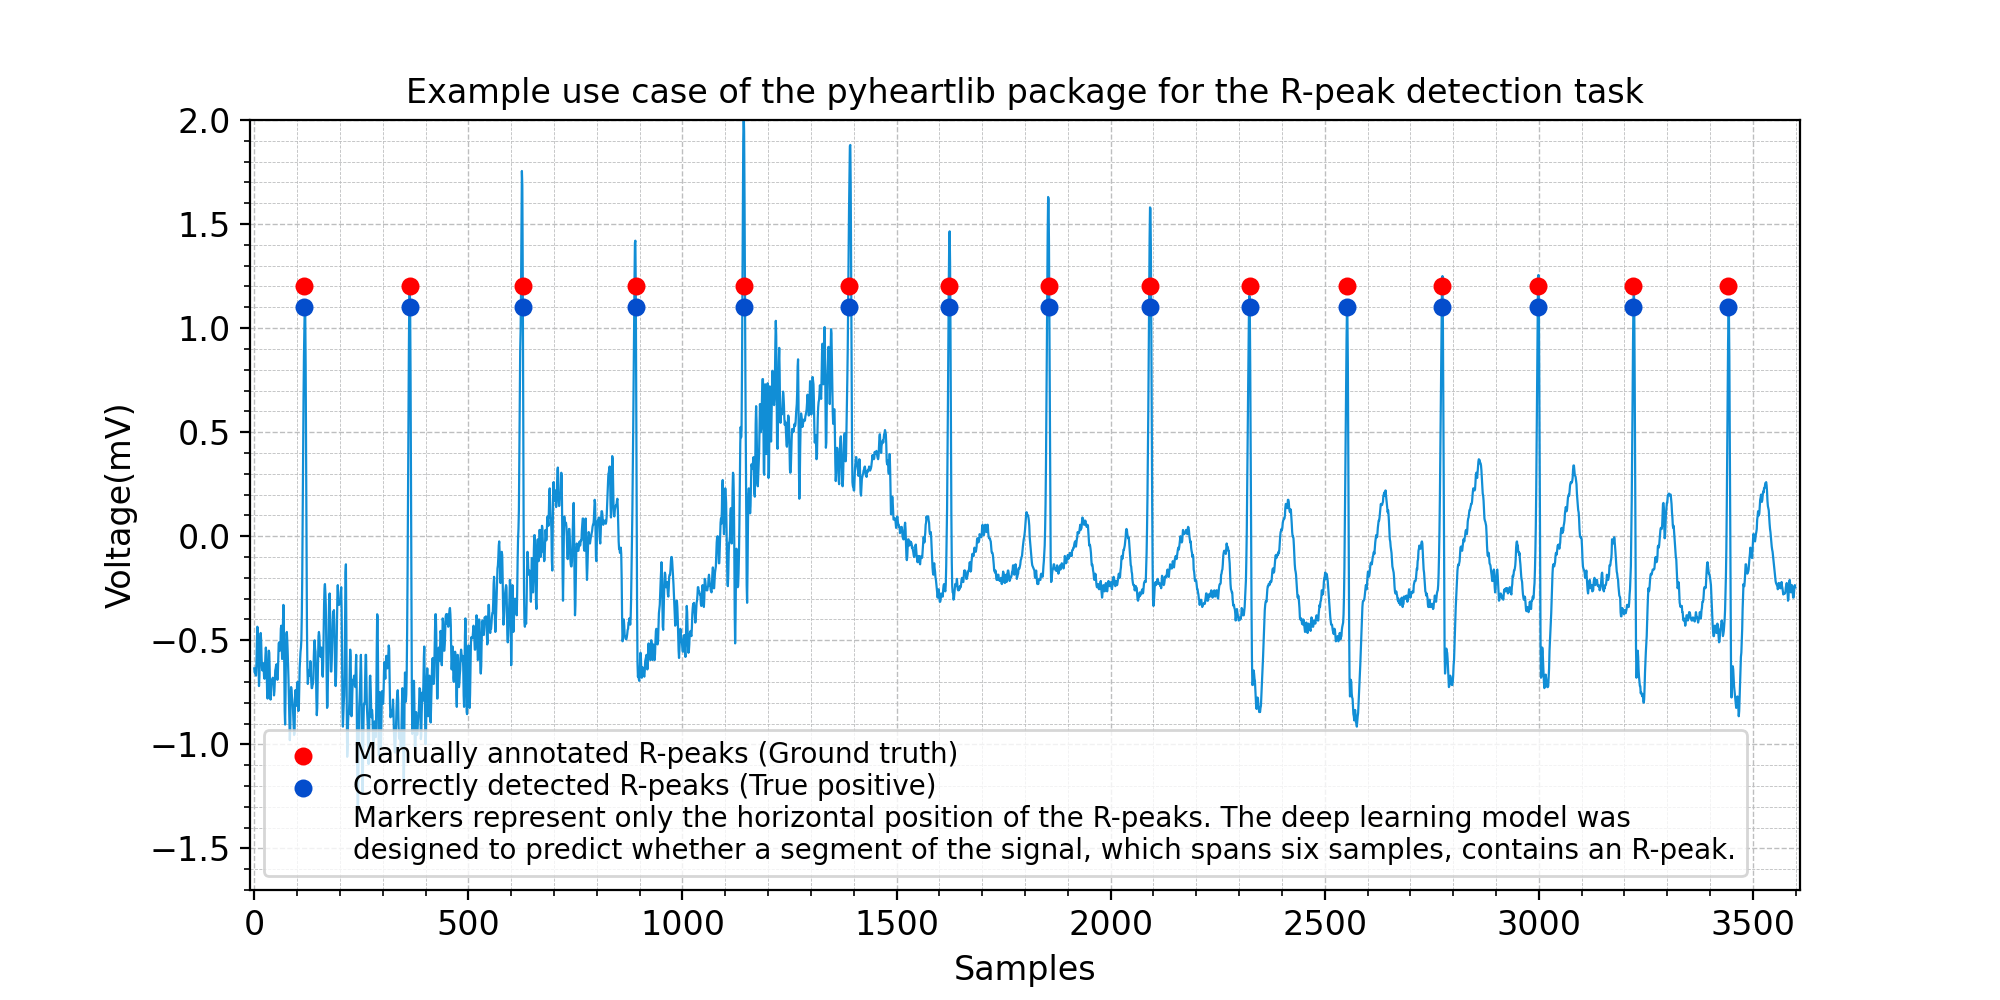

In [11]:
# Load the inference results on the test dataset
f = open("result.txt", "r")
print(f.read())

from IPython.display import Image

Image(filename="plots/3492.png", width=700)
